In [2]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve,auc    
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_df = pd.read_csv('Train Data.csv')
validation_df = pd.read_csv('Validation Data.csv')
test_df = pd.read_csv('Test Data.csv')

In [4]:
train_df['has_ci'] = np.where(train_df['131366-0.0'].notna(), 1, 0)
train_df = train_df.drop('131366-0.0', axis=1)

In [5]:
validation_df['has_ci'] = np.where(validation_df['131366-0.0'].notna(), 1, 0)
validation_df = validation_df.drop('131366-0.0', axis=1)

In [6]:
test_df['has_ci'] = np.where(test_df['131366-0.0'].notna(), 1, 0)
test_df = test_df.drop('131366-0.0', axis=1)

In [7]:
X_train = train_df.drop(columns=['has_ci'])
y_train = train_df['has_ci']

X_valid = validation_df.drop(columns=['has_ci'])
y_valid = validation_df['has_ci']

X_test = test_df.drop(columns=['has_ci'])
y_test = test_df['has_ci']

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
params = {
    'objective': 'binary:logistic',  # Use 'reg:squarederror' for regression tasks
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'logloss',  # Use 'rmse' for regression
    'missing': None  # Handles missing values automatically
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

In [10]:
model = xgb.train(params, dtrain, num_boost_round=100, evals=evals, early_stopping_rounds=10)

[0]	train-logloss:0.48880	eval-logloss:0.49519
[1]	train-logloss:0.47728	eval-logloss:0.48851
[2]	train-logloss:0.46782	eval-logloss:0.48432
[3]	train-logloss:0.45979	eval-logloss:0.48143
[4]	train-logloss:0.45284	eval-logloss:0.48063
[5]	train-logloss:0.44689	eval-logloss:0.47845
[6]	train-logloss:0.44172	eval-logloss:0.47762
[7]	train-logloss:0.43660	eval-logloss:0.47634
[8]	train-logloss:0.43118	eval-logloss:0.47558
[9]	train-logloss:0.42626	eval-logloss:0.47516
[10]	train-logloss:0.42269	eval-logloss:0.47456
[11]	train-logloss:0.41849	eval-logloss:0.47402
[12]	train-logloss:0.41442	eval-logloss:0.47427
[13]	train-logloss:0.41163	eval-logloss:0.47414
[14]	train-logloss:0.40748	eval-logloss:0.47328
[15]	train-logloss:0.40478	eval-logloss:0.47330
[16]	train-logloss:0.40122	eval-logloss:0.47314
[17]	train-logloss:0.39849	eval-logloss:0.47332
[18]	train-logloss:0.39516	eval-logloss:0.47347
[19]	train-logloss:0.39208	eval-logloss:0.47414
[20]	train-logloss:0.39064	eval-logloss:0.47407
[2

In [11]:
y_pred = model.predict(dtest)
y_pred

array([0.26169255, 0.33861938, 0.14470585, ..., 0.4290275 , 0.03917827,
       0.2521399 ], dtype=float32)

In [26]:
threshold = 0.31
predictions = (y_pred >= threshold).astype(int)

# For classification
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100.0:.2f}%")

# For regression, use mean squared error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Accuracy: 75.57%
Mean Squared Error: 0.2442957103742014


In [27]:
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[6748 1099]
 [1310  704]]


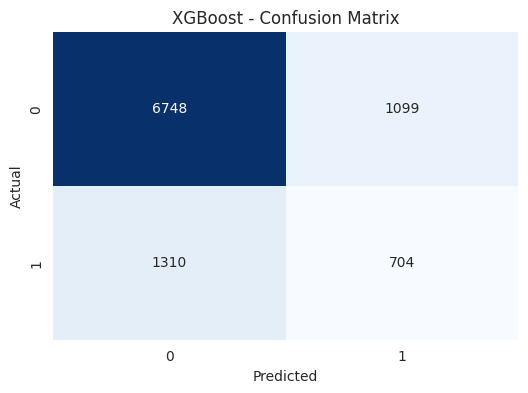

In [28]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost - Confusion Matrix')
plt.show()



In [29]:
# Optional: Classification report
print("\nClassification Report:")
print(classification_report(y_test, predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      7847
           1       0.39      0.35      0.37      2014

    accuracy                           0.76      9861
   macro avg       0.61      0.60      0.61      9861
weighted avg       0.75      0.76      0.75      9861



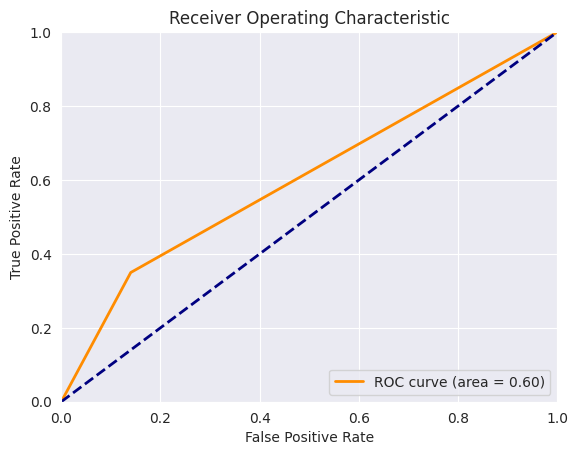

In [30]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [31]:
explainer = shap.TreeExplainer(model)

In [32]:
shap_values = explainer.shap_values(X_valid)


In [33]:
# Calculate the mean absolute SHAP value for each feature
shap_importance = pd.DataFrame({
    'Feature': X_valid.columns,
    'Importance': np.mean(np.abs(shap_values), axis=0)
})

# Sort by importance
shap_importance = shap_importance.sort_values(by='Importance', ascending=False)

# Get top 10 features
top_10_shap_features = shap_importance.head(10)

print("Top 10 most important features (based on SHAP values):")
print(top_10_shap_features)

Top 10 most important features (based on SHAP values):
      Feature  Importance
87   4080-0.0    0.268906
1      31-0.0    0.160977
10   1050-0.0    0.094794
20   1249-0.0    0.090325
15   1190-0.0    0.087286
8     914-0.0    0.084055
96  21001-0.0    0.075692
91   6144-0.0    0.064589
9     981-0.0    0.061576
53   1677-0.0    0.058016


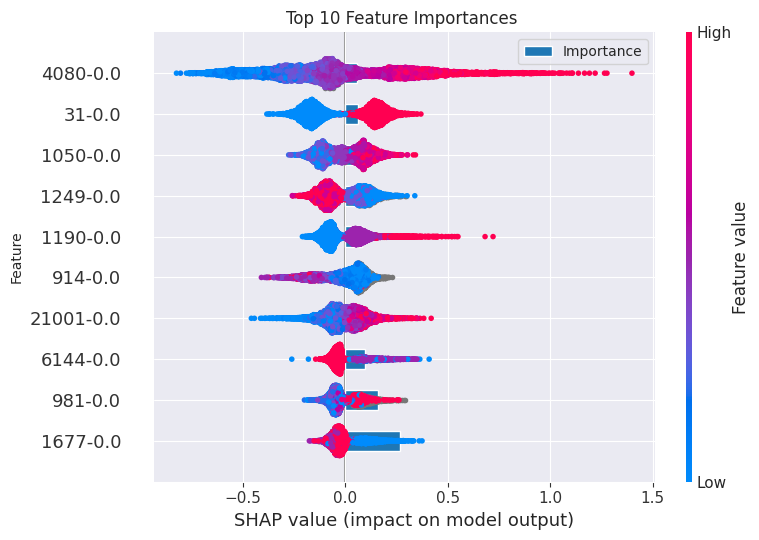

In [34]:
# Bar chart for top 10 features
top_10_shap_features.plot(kind='barh', x='Feature', title='Top 10 Feature Importances ')

# SHAP summary plot (for all features)
shap.summary_plot(shap_values, X_valid, max_display=10)